# Pulse Sequence Diagnostics (Minimal)

This notebook demonstrates three core checks using the refactored pulse system and public APIs:
- Envelope type comparison (cos^2 vs gaussian)
- Spectral comparison of single-pulse envelopes
- Dynamic modification of phases and delays in a 3-pulse sequence

In [ ]:
# Minimal imports for this streamlined notebook
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from qspectro2d.core.laser_system.laser_class import LaserPulseSequence
from qspectro2d.core.laser_system.laser_fcts import pulse_envelopes
from qspectro2d.visualization.plotting import plot_pulse_envelopes

from plotstyle import COLORS, LINE_STYLES, init_style
init_style()


custom_dir = Path("test_pulses")
custom_dir.mkdir(exist_ok=True)


# Helper: summed envelope using module function
def envelopes(times: np.ndarray, seq: LaserPulseSequence) -> np.ndarray:
    return pulse_envelopes(times, seq)


def plot_envelopes(times: np.ndarray, seq: LaserPulseSequence, ax=None, label_prefix: str = "env"):
    fig, ax = plot_pulse_envelopes(times, seq, ax=ax, show_legend=True)
    ax.set_title("Summed pulse envelopes")
    return fig, ax

## 1. Envelope Type Comparison

Section 1: Envelope type comparison (cos^2 vs gaussian)


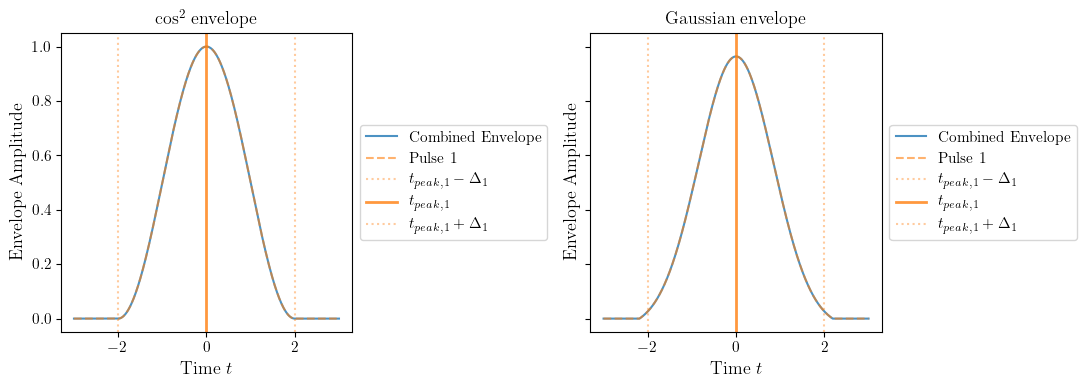

In [2]:
# Envelope Type Comparison using from_pulse_delays
print("Section 1: Envelope type comparison (cos^2 vs gaussian)")

# Parameters
fwhm       = 2.0     # fs (FWHM)
amplitude  = 1.0     # a.u.
carrier_cm = 16000.0 # cm^-1
phase_val  = np.pi/2 # rad

# Build single-pulse sequences via delays (single pulse -> empty delays list)
seq_cos2  = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=amplitude,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=carrier_cm,
    envelope_type="cos2",
    relative_E0s=[1.0],
    phases=[phase_val],
)
seq_gauss = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[],
    base_amplitude=amplitude,
    pulse_fwhm_fs=fwhm,
    carrier_freq_cm=carrier_cm,
    envelope_type="gaussian",
    relative_E0s=[1.0],
    phases=[phase_val],
)

# Manually relocate peak of single pulse to desired t_peak (first pulse defaults to 0 fs)
local_times = np.linspace(- 1.5 * fwhm, + 1.5 * fwhm, 800)

fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
plot_envelopes(local_times, seq_cos2, ax=axes[0], label_prefix="cos2")
axes[0].set_title(r"cos$^2$ envelope")
plot_envelopes(local_times, seq_gauss, ax=axes[1], label_prefix="gaussian")
axes[1].set_title(r"Gaussian envelope")
fig.tight_layout()

## 2. Multi-Pulse Gaussian Sequence Diagnostics

In [3]:
# Multi-Pulse Gaussian Diagnostics (kept minimal)
print("Section 2: Multi-pulse gaussian diagnostics (envelope only)")

times = np.linspace(-2.0, 10.0, 600)

# Build 3-pulse sequence from delays: delays define gaps between consecutive peaks
# Example: peak times at 0.0, 3.0, 6.0 fs -> delays [3.0, 3.0]
seq_multi = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[3.0, 3.0],
    base_amplitude=1.0,
    pulse_fwhm_fs=1.0,
    carrier_freq_cm=10000.0,
    envelope_type="gaussian",
    relative_E0s=[1.0, 1.5, 0.8],
    phases=[0.0, 1.57, 3.14],
)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
plot_envelopes(times, seq_multi, ax=ax1, label_prefix="gaussian")
ax1.set_title(r"Three-pulse Gaussian sequence (envelopes)")
from qspectro2d.visualization.plotting import plot_e_pulses
plot_e_pulses(times, seq_multi, ax=ax2)
ax2.set_title(r"Three-pulse Gaussian sequence (electric fields)")
fig.tight_layout()
print("‚úì Multi-pulse gaussian diagnostic ready")
seq_multi.pulse_phases = [0.5, 1.0, 2.0]
seq_multi.pulse_delays = [1.0, 5.0]
ax3.set_title(r"CHANGED PHASES and DELAYS")
plot_e_pulses(times, seq_multi, ax=ax3)

Section 2: Multi-pulse gaussian diagnostics (envelope only)
‚úì Multi-pulse gaussian diagnostic ready


(<Figure size 800x1000 with 3 Axes>,
 <Axes: title={'center': 'RWA Electric Field Components'}, xlabel='Time $t$', ylabel='Electric Field (RWA)'>)

In [4]:
from qspectro2d.config import create_base_sim_oqs
from qspectro2d.spectroscopy.e_field_1d import sim_with_only_pulses
# Build base simulation (applies CLI overrides inside)
from thesis_paths import SIM_CONFIGS_DIR
config_path = SIM_CONFIGS_DIR / "template.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path)
seq_multi = sim_oqs.laser

# Multi-Pulse Gaussian Diagnostics (kept minimal)
print("Section 2: Multi-pulse gaussian diagnostics (envelope only)")

times = sim_oqs.times_local

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10))
plot_envelopes(times, seq_multi, ax=ax1, label_prefix="gaussian")
ax1.set_title(r"Three-pulse Gaussian sequence (envelopes)")
from qspectro2d.visualization.plotting import plot_e_pulses
plot_e_pulses(times, seq_multi, ax=ax2)
ax2.set_title(r"Three-pulse Gaussian sequence (electric fields)")
fig.tight_layout()
print("‚úì Multi-pulse gaussian diagnostic ready")
seq_multi.pulse_phases = [0.5, 1.0, 2.0]
new_delays = [times[-1]/4, times[-1]/2]
sim_oqs.update_delays(*new_delays)
seq_multi.pulse_delays = new_delays
print("NEW TIMES ARE: ", seq_multi.pulse_delays)
print("And the Laser has: ", sim_oqs.laser.pulse_delays)
t_coh = sim_oqs.simulation_config.t_coh
t_wait = sim_oqs.simulation_config.t_wait
print("and the config uses:", t_coh, t_wait)
ax3.set_title(r"CHANGED PHASES and DELAYS")
plot_e_pulses(times, seq_multi, ax=ax3)
norms_all = np.array([sim_oqs.evo_obj(t).norm() for t in times])

sim_i = sim_with_only_pulses(sim_oqs, [1, 2])
norms_only = np.array([sim_i.evo_obj(t).norm() for t in times])
ax4.set_title(r"compare the hamiltonian norms")
ax4.plot(times, norms_all, color="C1", ls="-", label=r"$\|H(t)\|$ (all pulses)")
ax4.plot(times, norms_only, color="C3", ls=":", linewidth=3, label=r"$\|H(t)\|$ (pulses 1,2)")
ax4.legend()

üîß Configured to use max_workers=8 for parallel tasks.


üîß Base simulation created from config (overrides applied early).
üîç Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: Paper_eqs
Time range: t0=-100.000, t_max=3400.000, dt=10.000000
Number of time points: 351
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[[2], [2]], [[2], [2]]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Applying RWA phase factors: n_atoms=1, omega_laser=3.0139183281479043 [fs^-1]
=== STATE-BY-STATE ANALYSIS ===
‚úÖ Checks passed. DM remains Hermitian and positive.
Final state trace: 1.000000
Final state min eigenvalue: 0.0000000000
############################################################
‚úÖ Solver validation worked: Evolution becomes unphysical at (inf √ó t_max)
Section 2: Multi-pulse gaussian diagnostics (envelope only)
‚úì

Length of non-ground state indices: 1730
the first 10 states are: [Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]], Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]

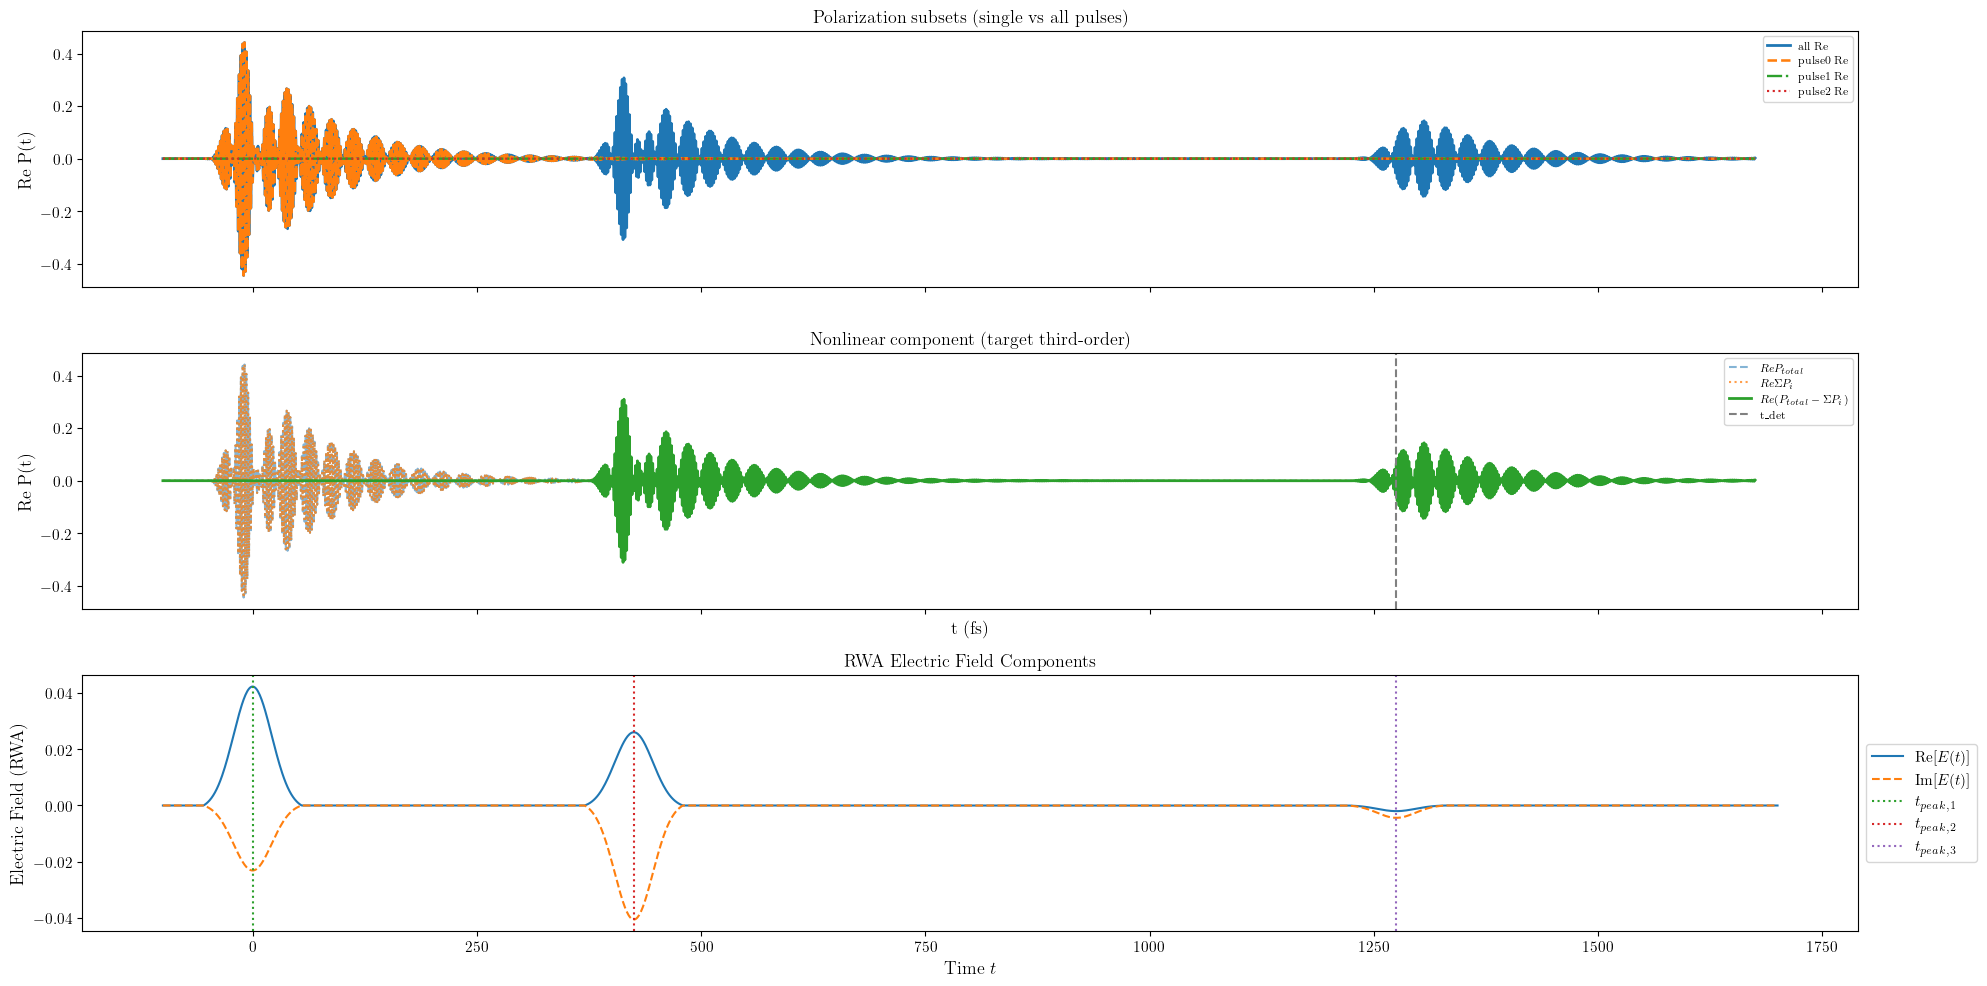

In [5]:
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window
# 2. Evolution subsets: all pulses vs single pulse vs modified amplitude
subset_specs = {
    'all': list(range(len(sim_oqs.laser.pulses))),
}
# Add individual pulses
for i in range(len(sim_oqs.laser.pulses)):
    subset_specs[f'pulse{i}'] = [i]

pol_datas = {}
base_window = sim_oqs.times_local  # detection / plotting window (assumed uniform grid)

for label, idxs in subset_specs.items():
    sim_sub = sim_with_only_pulses(sim_oqs, idxs) if label != 'all' else sim_oqs
    t_actual, P = compute_polarization_over_window(sim_sub, base_window)
    pol_datas[label] = P

# Build nonlinear component: P_total - Œ£_i P_i
P_total = pol_datas['all']
linear_sum = np.zeros_like(P_total, dtype=complex)
for i in range(len(sim_oqs.laser.pulses)):
    linear_sum += pol_datas[f'pulse{i}']
pol_nonlinear = P_total - linear_sum  # store for later reuse if needed

# Plotting: two subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(20,10), sharex=True)
ax1, ax2, ax3 = axes

# Subplot 1: original subset comparison (real part)
for idx, (k, v) in enumerate(pol_datas.items()):
    ax1.plot(t_actual, np.real(v), color=COLORS[idx % len(COLORS)], linewidth=2-0.15*idx, label=f'{k} Re')
ax1.set_ylabel('Re P(t)')
ax1.set_title('Polarization subsets (single vs all pulses)')
ax1.legend(loc='best', fontsize=8)

# Subplot 2: nonlinear component extraction
ax2.plot(t_actual, np.real(P_total), label='$Re P_{total}$', linestyle='--', color=COLORS[0], alpha=0.55)
ax2.plot(t_actual, np.real(linear_sum), label='$Re \Sigma P_i$', linestyle=':', color=COLORS[1], alpha=0.75)
ax2.plot(t_actual, np.real(pol_nonlinear), label='$Re (P_{total} - \Sigma P_i)$', color=COLORS[2], linewidth=2.0)
# make a vertical line at t_det_actual[0]
ax2.axvline(x=sim_oqs.t_det_actual[0], color='gray', linestyle='--', label='t_det')
ax2.set_ylabel('Re P(t)')
ax2.set_xlabel('t (fs)')
ax2.set_title('Nonlinear component (target third-order)')
ax2.legend(loc='best', fontsize=8)
if sim_oqs.simulation_config.rwa_sl:
    plot_e_pulses(times, sim_oqs.laser, ax=ax3)
else:
    plot_e_pulses(times, sim_oqs.laser, ax=ax3)
plt.tight_layout()
plt.show()

## 2. Spectral Envelope Comparison

Section 3: Spectral comparison of envelope shapes
‚úì Spectral comparison ready


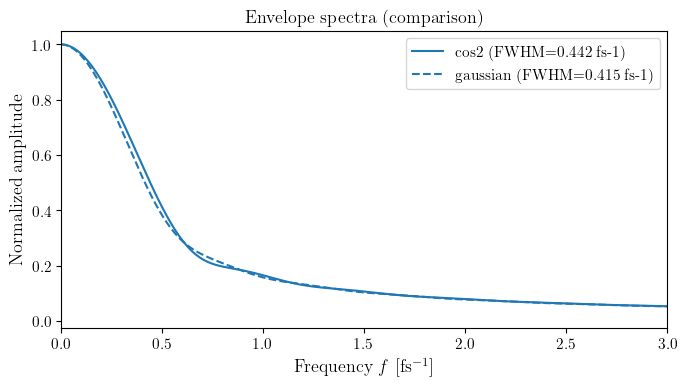

In [6]:
# Spectral comparison (FFT of envelopes)
print("Section 3: Spectral comparison of envelope shapes")

def spectral_envelope(times: np.ndarray, seq: LaserPulseSequence):
    env = envelopes(times, seq)
    N   = len(times)
    dt  = times[1] - times[0]
    N_fft = 1 << (N - 1).bit_length()  # next power of two
    spec = np.fft.fft(env, n=N_fft)
    freq = np.fft.fftfreq(N_fft, dt)
    pos  = freq >= 0
    mag  = np.abs(spec[pos])
    if mag.max() > 0:
        mag = mag / mag.max()
    # FWHM estimate
    idx = np.where(mag >= 0.5)[0]
    fwhm_freq = (freq[pos][idx[-1]] - freq[pos][idx[0]]) if len(idx) > 1 else 0.0
    return freq[pos], mag, fwhm_freq

DT     = 0.05  # fs
T_MAX  = 300.0 # fs
spec_t = np.arange(0.0, T_MAX, DT)

# Build fresh single-pulse sequences at t=0 for spectral analysis
seq_cos2_spec  = LaserPulseSequence.from_pulse_delays([], amplitude, fwhm, carrier_cm, "cos2", [1.0], [phase_val])
seq_gauss_spec = LaserPulseSequence.from_pulse_delays([], amplitude, fwhm, carrier_cm, "gaussian", [1.0], [phase_val])

f_cos, mag_cos, fwhm_cos = spectral_envelope(spec_t, seq_cos2_spec)
f_gau, mag_gau, fwhm_gau = spectral_envelope(spec_t, seq_gauss_spec)

figs, axs = plt.subplots(1, 1, figsize=(7, 4))
axs.plot(f_cos, mag_cos, label=f"cos2 (FWHM={fwhm_cos:.3f} fs-1)")
axs.plot(f_gau, mag_gau, label=f"gaussian (FWHM={fwhm_gau:.3f} fs-1)")
axs.set_xlim(0, 3.0)
axs.set_xlabel(r"Frequency $f$ [fs$^{-1}$]")
axs.set_ylabel("Normalized amplitude")
axs.set_title("Envelope spectra (comparison)")
axs.legend()
figs.tight_layout()
print("‚úì Spectral comparison ready")

## 4. Advanced Plotting Demonstrations

Section 4: Dynamic modification of phases and delays
‚úì Dynamic updates applied


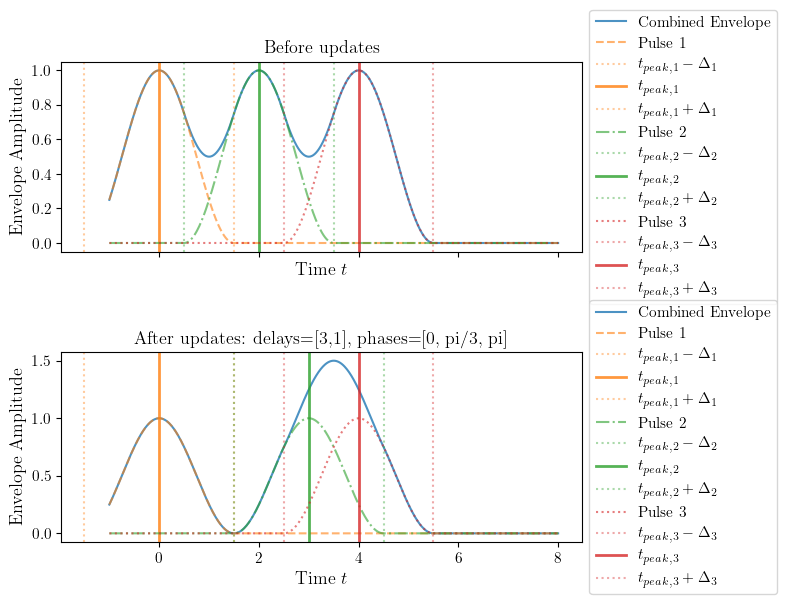

In [7]:
# Dynamic modification: phases and delays
print("Section 4: Dynamic modification of phases and delays")

# Start from a simple 3-pulse cos2 sequence with equal delays
seq_dyn = LaserPulseSequence.from_pulse_delays(
    pulse_delays=[2.0, 2.0],
    base_amplitude=1.0,
    pulse_fwhm_fs=1.5,
    carrier_freq_cm=12000.0,
    envelope_type="cos2",
    relative_E0s=[1.0, 1.0, 1.0],
    phases=[0.0, 0.0, 0.0],
)

t_axis = np.linspace(-1.0, 8.0, 600)
fig3, (ax3a, ax3b) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plot_envelopes(t_axis, seq_dyn, ax=ax3a, label_prefix="before")
ax3a.set_title("Before updates")

# Update: change delays and phases dynamically
seq_dyn.pulse_delays = [3.0, 1.0]          # setter should recompute peak times
seq_dyn.pulse_phases = [0.0, np.pi/3, np.pi]
plot_envelopes(t_axis, seq_dyn, ax=ax3b, label_prefix="after")
ax3b.set_title("After updates: delays=[3,1], phases=[0, pi/3, pi]")
fig3.tight_layout()
print("‚úì Dynamic updates applied")